In [1]:
%matplotlib inline
import csv
import pandas as pd
def Read_Data():
    X = []
    y = []
    f = open('lang_data.csv')
    csv_f = csv.reader(f)

    for row in csv_f:
        if row[1]!='language':
            X.append(row[0])
            y.append(row[1])
    return X,y

In [2]:
Corpus,y = Read_Data()

In [3]:
def Class_labels(List):
    Unique_terms = [] 
    y = []
    for word in List:
        if word not in Unique_terms:
            Unique_terms.append(word)
    for labels in List:
        if labels == Unique_terms[0]:
            y.append(0)
        elif labels == Unique_terms[1]:
            y.append(1)
        else:
            y.append(2)
    return Unique_terms, y        

In [4]:
Labels, y= Class_labels(y)

In [5]:
import string

def Data_Cleaning(Corpus):
    for i in range(len(Corpus)):
        Corpus[i] = filter(lambda x: x in string.printable, Corpus[i])
        #conversion to lower case 
        temp = []
        for j in Corpus[i].split():
            temp.append(j.lower())
        Corpus[i] = ' '.join(temp)
        #removal of panctuation marks
        for c in string.punctuation:
            Corpus[i] = Corpus[i].replace(c," ")
        Corpus[i] = Corpus[i].replace("  "," ")
    return Corpus
        

In [6]:
Corpus = Data_Cleaning(Corpus)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
def Feature_Extraction_TFIDF(Corpus):
    vectorizer = CountVectorizer(min_df=1)
    X = vectorizer.fit_transform(Corpus)
    X = X.toarray()
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(X)
    return tfidf.toarray()

In [8]:
X = Feature_Extraction_TFIDF(Corpus)

In [9]:
import numpy as np
def Check_Content(X,y):
    temp_X = []
    temp_y = []
    for i in range(len(X)):
        if np.mean(X[i])!=0.0:
            temp_X.append(X[i])
            temp_y.append(y[i])
    return np.array(temp_X,dtype=float), temp_y

In [10]:
X, y = Check_Content(X,y)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
def Cosine_Similarity(X):
    return cosine_similarity(X, X)

In [12]:
X = Cosine_Similarity(X)

In [13]:
from sklearn import preprocessing
X = preprocessing.normalize(X, norm='l2')

In [14]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [15]:
from sklearn.decomposition import PCA
def Feature_Reduction_PCA(X):
    pca = PCA(n_components=50)
    X_r2 = pca.fit(X)
    return X_r2.transform(X)

In [16]:
X = Feature_Reduction_PCA(X)

In [17]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(kernel='rbf', probability=True, C=10, gamma=0.01).fit(X_train_transformed, y_train)

X_test_transformed = scaler.transform(X_test)
print clf.score(X_test_transformed, y_test) 

0.978280542986


In [18]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
y_predicted = clf.predict(X_test_transformed)

# performance
print "Classification report for %s" % clf
print
print metrics.classification_report(y_test, y_predicted)
print
print "Confusion matrix"
print metrics.confusion_matrix(y_test, y_predicted)

Classification report for SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       813
          1       0.97      0.97      0.97       264
          2       0.94      0.57      0.71        28

avg / total       0.98      0.98      0.98      1105


Confusion matrix
[[809   3   1]
 [  8 256   0]
 [  8   4  16]]


/home/melvin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Binarize the output
y = label_binarize(np.array(y), classes=[0, 1, 2])
y_train = label_binarize(y_train, classes=[0, 1, 2])
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True, C=10, gamma=0.01))
y_score = classifier.fit(X_train_transformed, y_train).decision_function(X_test_transformed)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

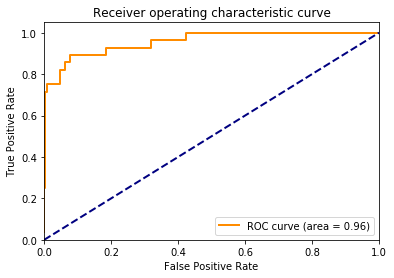

In [20]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()